# LAND LEASE PRICE RECOMMENDER

### Import dependencies

In [1]:
#import libraries
import pandas as pd 
import numpy as np
import random
import math
#import source data
url_1 = 'https://raw.githubusercontent.com/PhilipHarvey20/Land-Lease-Price-Generator/master/acreage_price_by_state.csv'

### How features contribute to price

In [2]:
#  BASE_STATE_PRC_HUNTING: avg price per acre by state
#  Minimum of $65 for daily hunts
#  ACREAGE_PRICE_DAILY: ((log(acreage)) * (BASE_STATE_PRC_HUNTING))/30

### Create dataframe

In [3]:
# import csv
df = pd.read_csv(url_1)
# Create list of 50 unique states from the imported csv
STATE_LIST = df['STATE'].to_list()
# Create state price per acre lookup to join onto dataframe later
STATE_PRC_PER_ACRE_LOOKUP = df.drop_duplicates()
# Generate dataframe of 10k random states with base acreage price per state
random_list_10k_states = [STATE_LIST[random.randrange(len(STATE_LIST))] for i in range(10000)]
df = pd.DataFrame (random_list_10k_states, columns = ['STATE'])

In [4]:
df.shape

(10000, 1)

In [5]:
cols = ['STATE']
df = df.join(STATE_PRC_PER_ACRE_LOOKUP.set_index(cols), on=cols)
df.shape

(10000, 2)

In [6]:
df.shape

(10000, 2)

### Populate df with activity type, acreage, duration, and price

In [7]:
# rename column
df.rename(columns = {'STATE_PRC_PER_ACRE':'BASE_STATE_PRC_HUNTING'},inplace = True)

# Randomly populate activities 
activities = ['HUNTING','FISHING','CAMPING','HIKING','METAL DETECTING','FARMING','SHED ANTLERS','ARTIFACT HUNTING']
df['ACTIVITY_TYPE'] = np.random.choice(list(activities), len(df))

# Randomly populate acreages 
df['ACREAGE'] = np.random.randint(1, 200, df.shape[0])

# Calculate ACREAGE_PRICE_DAILY using the following formula: (log(acreage) * (base_state_price))/30
df['ACREAGE_PRICE_DAILY'] = np.nan
df['LOG2_BASE_STATE_PRC_HUNTING'] = np.log2(df.BASE_STATE_PRC_HUNTING)
df['LOG_BASE_STATE_PRC_HUNTING'] = np.log(df.BASE_STATE_PRC_HUNTING)
df.loc[df['ACTIVITY_TYPE']=='HUNTING', ['ACREAGE_PRICE_DAILY']] = df['LOG2_BASE_STATE_PRC_HUNTING'] * df['ACREAGE']
df['ACREAGE_PRICE_DAILY'] = (df['ACREAGE_PRICE_DAILY'].div(30).round(2)) + 10

# Randomly generate duration (i.e. # of days rented)
df['DURATION_days'] = np.random.randint(1, 365, df.shape[0])
# reorder df columns
df = df[['ACTIVITY_TYPE','STATE','DURATION_days','BASE_STATE_PRC_HUNTING','ACREAGE','ACREAGE_PRICE_DAILY', 'LOG_BASE_STATE_PRC_HUNTING','LOG2_BASE_STATE_PRC_HUNTING']]

### Apply duration discount

### Create duration discount up to 200 days (reaches maximum of 60% off at day 200)

Duration discount increases by .3% every day

In [8]:
duration_discount_multiplier = []
DURATION_days = []
x = .003
for day_num in range(200):
    DURATION_days.append(day_num)
    x += .003
    duration_discount_multiplier.append(1 - x)
duration_discount_multiplier = pd.DataFrame (duration_discount_multiplier, columns = ['duration_discount_multiplier'])
DURATION_days  = pd.DataFrame (DURATION_days, columns = ['DURATION_days'])
duration_discount_multiplier = duration_discount_multiplier.join(DURATION_days)
duration_discount_multiplier = duration_discount_multiplier[['DURATION_days','duration_discount_multiplier']]
df.shape
cols = ['DURATION_days']
df = df.join(duration_discount_multiplier.set_index(cols), on=cols)
df.loc[df['DURATION_days']>=200, ['duration_discount_multiplier']] = .397
df['TOTAL_ACREAGE_PRICE'] = (df['DURATION_days'] * df['ACREAGE_PRICE_DAILY'] * df['duration_discount_multiplier']).round(2)
# reorder df columns
df = df[['ACTIVITY_TYPE','STATE','BASE_STATE_PRC_HUNTING','ACREAGE_PRICE_DAILY', 'LOG_BASE_STATE_PRC_HUNTING','LOG2_BASE_STATE_PRC_HUNTING','duration_discount_multiplier','DURATION_days','ACREAGE', 'TOTAL_ACREAGE_PRICE']]

### Set minimum daily hunting price to 65

In [9]:
# Set the minimum daily acreage price to $60
df['TOTAL_ACREAGE_PRICE'] = np.where((df['ACTIVITY_TYPE']=='HUNTING') & (df['TOTAL_ACREAGE_PRICE']<60), 60, df['TOTAL_ACREAGE_PRICE']) 

In [10]:
HUNTING = df[df['ACTIVITY_TYPE']=='HUNTING']

<AxesSubplot:xlabel='ACREAGE', ylabel='TOTAL_ACREAGE_PRICE'>

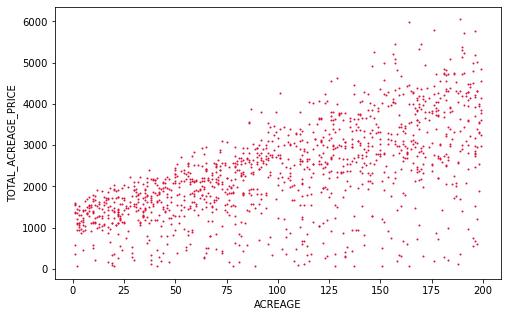

In [11]:
HUNTING.plot(kind='scatter', x='ACREAGE', y='TOTAL_ACREAGE_PRICE', s=1, c='crimson', figsize=(8, 5))

<AxesSubplot:xlabel='DURATION_days', ylabel='TOTAL_ACREAGE_PRICE'>

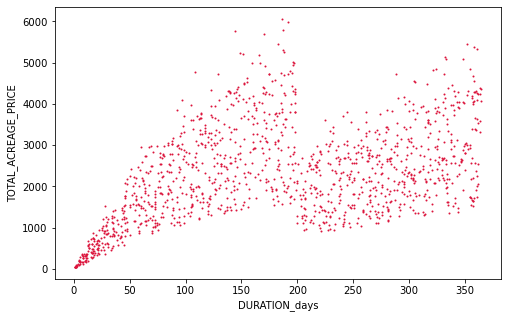

In [12]:
HUNTING.plot(kind='scatter', x='DURATION_days', y='TOTAL_ACREAGE_PRICE', s=1, c='crimson', figsize=(8, 5))

In [13]:
df[df['ACTIVITY_TYPE']=='HUNTING'].head(30)

,ACTIVITY_TYPE,STATE,BASE_STATE_PRC_HUNTING,ACREAGE_PRICE_DAILY,LOG_BASE_STATE_PRC_HUNTING,LOG2_BASE_STATE_PRC_HUNTING,duration_discount_multiplier,DURATION_days,ACREAGE,TOTAL_ACREAGE_PRICE
13,HUNTING,Washington,10.0,31.59,2.302585,3.321928,0.938,152,195,4503.98
33,HUNTING,Iowa,35.0,17.86,3.555348,5.129283,0.397,255,46,1808.06
50,HUNTING,Colorado,10.0,10.44,2.302585,3.321928,1.184,70,4,865.27
53,HUNTING,Tennessee,8.5,21.94,2.140066,3.087463,1.220,58,116,1552.47
54,HUNTING,California,10.0,13.76,2.302585,3.321928,1.031,121,34,1716.57
65,HUNTING,Missouri,25.0,14.33,3.218876,4.643856,0.839,185,28,2224.23
91,HUNTING,South Dakota,5.0,20.22,1.609438,2.321928,1.175,73,132,1734.37
96,HUNTING,New York,19.0,16.37,2.944439,4.247928,0.397,322,45,2092.64
100,HUNTING,West Virginia,11.0,24.18,2.397895,3.459432,1.370,8,123,265.01
104,HUNTING,Idaho,10.0,26.61,2.302585,3.321928,0.397,299,150,3158.69
